# Set up

In [1]:
# Install Disimpy

!pip install git+https://github.com/kerkelae/disimpy.git

  Cloning https://github.com/kerkelae/disimpy.git to /tmp/pip-req-build-zfvv9ymk
  Running command git clone -q https://github.com/kerkelae/disimpy.git /tmp/pip-req-build-zfvv9ymk
  Created wheel for disimpy: filename=disimpy-0.1.1-cp37-none-any.whl size=613478 sha256=ad765392fbcf63a76cd62342b2b49b26f9f9f74a3e4791eb94f17d913642677d
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzkjw_8x/wheels/b8/8e/1c/131e55695ea2e53d2461f9f899360c543f607bf898a02a691f
Successfully built disimpy


In [2]:
# Import the required packages and modules

import os
import numpy as np
import matplotlib.pyplot as plt

from disimpy import gradients, simulations, utils

In [3]:
# Check the available GPU

!nvidia-smi

Thu Jun 17 15:27:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Mount Google Drive if using Google Colaboratory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define path and load synthetic axons

path = '/content/drive/MyDrive/ufa-model-comparison/ConFiG'

def load_mesh(mesh_file):
    """Load mesh from ply file"""
    with open(mesh_file, 'r') as f:
        mesh_data = f.readlines()
    header = mesh_data[0:mesh_data.index('end_header\n')]
    i = [i for i, e in enumerate(header) if 'element vertex' in e][0]
    if header[i + 1:i + 4] != ['property float x\n', 'property float y\n',
                               'property float z\n']:
        raise Exception(
            'Unsupported mesh file (%s). ' % mesh_file +
            'Vertex positions must be the first vertex positions defined. ' +
            'Please see %s as an example of the supported format.' % (
                os.path.join(os.path.dirname(utils.__file__), 'tests',
                             'example_mesh.ply')))
    n_of_vertices = int([i for i in mesh_data if
                         i.startswith('element vertex ')][0].split()[-1])
    first_vertice_idx = mesh_data.index('end_header\n') + 1
    vertices = np.loadtxt(mesh_data[first_vertice_idx:first_vertice_idx +
                                    n_of_vertices])
    faces = np.loadtxt(mesh_data[first_vertice_idx + n_of_vertices::])[:, 1:4]
    mesh = np.zeros((faces.shape[0], 3, 3))
    for i in range(faces.shape[0]):
        mesh[i, :, :] = vertices[np.array(faces[i], dtype=int)][0:3, 0:3]
    mesh = np.add(mesh, - np.min(np.min(mesh, 0), 0))
    return mesh

mesh = load_mesh(
    os.path.join(path, 'cell_tissue_replicated_periodic.ply')) * 1e-6
mesh_size = np.max(np.max(mesh, 0), 0)
print(mesh_size)
print(mesh.shape)

[3.9320805e-05 3.9333205e-05 3.2000000e-05]
(1713598, 3, 3)


In [6]:
# Load simulation initial positions

n_s = int(6e5)
pos = np.zeros((n_s, 3))
for i in range(381):
    f = i + 1
    pos[int(i*1e3):int((i+1)*1e3), :] = np.loadtxt(
        os.path.join(path, 'intra_init_pos_%s.txt' % f))
pos[int(381e3)::, :] = np.loadtxt(os.path.join(path, 'extra_init_pos.txt'))

In [7]:
# Define diffusivity

diffusivity = 2e-9

In [8]:
# Define PRNG seed

seed = 123

In [9]:
# Load b-values and b-vectors

bvals = np.loadtxt(os.path.join(path, 'LTE-STE.bval'))[0:107] * 1e6
bvecs = np.round(np.loadtxt(os.path.join(path, 'LTE-STE.bvec'))[:, 0:107], 4).T
bvals[bvals == 0] = 1e-9
bs = np.unique(bvals)
bvals = np.concatenate([bvals, bvals])
bvecs = np.concatenate([bvecs, bvecs], axis=0)
lte_idx = np.arange(0, 107).astype(int)
ste_idx = np.arange(107, 2 * 107).astype(int)
lte_bvals = bvals[lte_idx]
ste_bvals = bvals[ste_idx]

In [10]:
# Define simulated substrate

substrate = {'type' : 'mesh',
             'mesh' : mesh,
             'initial positions' : pos,
             'periodic' : True,
             'N_sv' : 50}

# Simulation 1

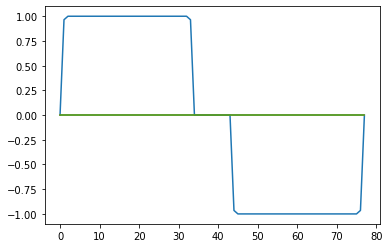

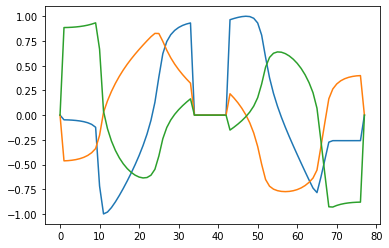

In [11]:
# Define gradient waveform

ste = np.loadtxt(os.path.join(path, 'waveform_STE.txt'))[np.newaxis, :, :]
lte = np.loadtxt(os.path.join(path, 'waveform_LTE.txt'))[np.newaxis, :, :]
plt.plot(lte[0])
plt.show()
plt.plot(ste[0])
plt.show()


# Create gradient array

T = 80e-3
n_t = int(1e4)
gradient = np.concatenate(
    [lte for i in range(107)] + [ste for i in range(107)], axis=0)
dt = T / (gradient.shape[1] - 1)
Rs = [utils.vec2vec_rotmat(np.array([1., 0, 0]), i) if np.linalg.norm(i) != 0 
      else np.eye(3) for i in bvecs]
gradient = gradients.rotate_gradient(gradient, Rs)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bvals)

Starting simulation
The trajectories file will be up to 0.75 GB
Number of spins = 1000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


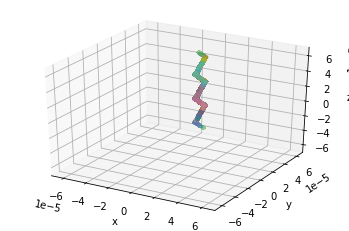

In [12]:
# Show an example of diffusion in periodic fibres

N = 1000
fibre_substrate = {'type' : 'mesh',
                   'mesh' : mesh,
                   'initial positions' : pos[0:N],
                   'periodic' : True,
                   'N_sv' : 50}

signals = simulations.simulation(
    N, diffusivity, gradient, dt, fibre_substrate, trajectories='traj.txt')

trajectories = np.loadtxt('traj.txt')
trajectories = trajectories.reshape(
    (trajectories.shape[0], int(trajectories.shape[1] / 3), 3))

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(trajectories.shape[1]):
    ax.plot(trajectories[:, i, 0],
            trajectories[:, i, 1],
            trajectories[:, i, 2],
            alpha=.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-np.max(trajectories), np.max(trajectories)])
ax.set_ylim([-np.max(trajectories), np.max(trajectories)])
ax.set_zlim([-np.max(trajectories), np.max(trajectories)])
ax.ticklabel_format(style='sci', scilimits=(0, 0))
plt.show()

In [14]:
# Run simulation with QTE (takes ~45 min)

signals_1 = simulations.simulation(n_s, diffusivity, gradient, dt, substrate,
                                   all_signals=True, seed=seed)
np.save(os.path.join(path, 'simulated_signals_1_seed%s.npy' % seed), signals_1)

Starting simulation
Number of spins = 600000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


In [15]:
# Repeat simulation with different random number seeds to quantify variance

seeds = [1, 12, 1234, 12345, 123456, 1234567, 12345678, 123456789, 666]
for seed in seeds:
    signals_1 = simulations.simulation(n_s, diffusivity, gradient, dt,
                                       substrate, all_signals=True, seed=seed)
    np.save(os.path.join(path, 'simulated_signals_1_seed%s.npy' % seed),
            signals_1)
seed = 123

Starting simulation
Number of spins = 600000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


/usr/local/lib/python3.7/dist-packages/disimpy/simulations.py:1414: UserWarning: Maximum number of iterations was exceeded in the intersection check algorithm for walkers [446686].
  'check algorithm for walkers %s.' % np.where(iter_exc)[0])


Starting simulation
Number of spins = 600000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


/usr/local/lib/python3.7/dist-packages/disimpy/simulations.py:1414: UserWarning: Maximum number of iterations was exceeded in the intersection check algorithm for walkers [595825].
  'check algorithm for walkers %s.' % np.where(iter_exc)[0])


Starting simulation
Number of spins = 600000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


/usr/local/lib/python3.7/dist-packages/disimpy/simulations.py:1414: UserWarning: Maximum number of iterations was exceeded in the intersection check algorithm for walkers [257098 393474].
  'check algorithm for walkers %s.' % np.where(iter_exc)[0])


Starting simulation
Number of spins = 600000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.
Starting simulation
Number of spins = 600000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


/usr/local/lib/python3.7/dist-packages/disimpy/simulations.py:1414: UserWarning: Maximum number of iterations was exceeded in the intersection check algorithm for walkers [418078].
  'check algorithm for walkers %s.' % np.where(iter_exc)[0])


Starting simulation
Number of spins = 600000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


/usr/local/lib/python3.7/dist-packages/disimpy/simulations.py:1414: UserWarning: Maximum number of iterations was exceeded in the intersection check algorithm for walkers [48647].
  'check algorithm for walkers %s.' % np.where(iter_exc)[0])


Starting simulation
Number of spins = 600000
Number of steps = 10000
Step length = 3.1184411690258525e-07 m
Step duration = 8.103896103896104e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


/usr/local/lib/python3.7/dist-packages/disimpy/simulations.py:1414: UserWarning: Maximum number of iterations was exceeded in the intersection check algorithm for walkers [347207].
  'check algorithm for walkers %s.' % np.where(iter_exc)[0])


# Simulation 2


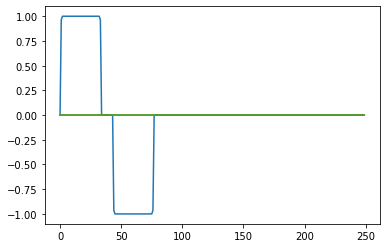

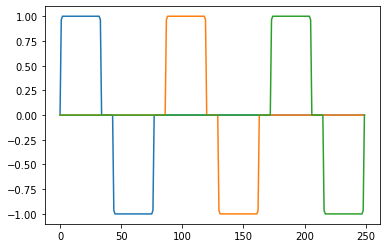

In [16]:
# Define waveforms

lte = np.loadtxt(os.path.join(path, 'waveform_LTE.txt'))
n_zeros = 8
ste = np.zeros((lte.shape[0] * 3 + n_zeros * 2, 3))
ste[0:78, 0] = lte[:, 0] 
ste[78 + n_zeros:78 + n_zeros + 78, 1] = lte[:, 0] 
ste[78 + n_zeros + 78 + n_zeros::, 2] = lte[:, 0] 
ste = ste[np.newaxis, :, :]
lte = np.copy(ste)
lte[:, :, 1::] = 0
plt.plot(lte[0])
plt.show()
plt.plot(ste[0])
plt.show()


# Create gradient array

T = 256e-3
n_t = 31720
gradient = np.concatenate(
    [lte for i in range(107)] + [ste for i in range(107)], axis=0)
dt = T / (gradient.shape[1] - 1)
Rs = [utils.vec2vec_rotmat(np.array([1., 0, 0]), i) if np.linalg.norm(i) != 0 
      else np.eye(3) for i in bvecs]
gradient = gradients.rotate_gradient(gradient, Rs)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bvals)

In [17]:
# Run simulation with TDE1

signals_2 = simulations.simulation(n_s, diffusivity, gradient, dt, substrate,
                                   all_signals=True, seed=seed)
np.save(os.path.join(path, 'simulated_signals_2_seed%s.npy' % seed), signals_2)

Starting simulation
Number of spins = 600000
Number of steps = 31720
Step length = 3.118274528028085e-07 m
Step duration = 8.103030026790645e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


/usr/local/lib/python3.7/dist-packages/disimpy/simulations.py:1414: UserWarning: Maximum number of iterations was exceeded in the intersection check algorithm for walkers [ 54111 181832 306600 376725 397788 399310 447374 512704 514718].
  'check algorithm for walkers %s.' % np.where(iter_exc)[0])


# Simulation 3

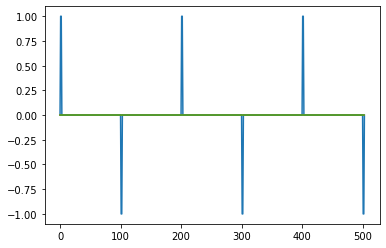

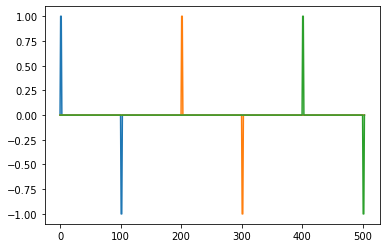

8.103545301069219e-06

In [18]:
# Define waveforms

lte = np.zeros((504, 3))
lte[1:3, 0] = 1
lte[101:103, 0] = -1
lte[201:203, 0] = 1
lte[301:303, 0] = -1
lte[401:403, 0] = 1
lte[501:503, 0] = -1
lte = lte[np.newaxis, :, :]
ste = np.zeros((504, 3))
ste[1:3, 0] = 1
ste[101:103, 0] = -1
ste[201:203, 1] = 1
ste[301:303, 1] = -1
ste[401:403, 2] = 1
ste[501:503, 2] = -1
ste = ste[np.newaxis, :, :]
plt.plot(lte[0])
plt.show()
plt.plot(ste[0])
plt.show()


# Create gradient array

T = 503e-3
n_t = 62195
gradient = np.concatenate(
    [lte for i in range(107)] + [ste for i in range(107)], axis=0)
dt = T / (gradient.shape[1] - 1)
Rs = [utils.vec2vec_rotmat(np.array([1., 0, 0]), i) if np.linalg.norm(i) != 0 
      else np.eye(3) for i in bvecs]
gradient = gradients.rotate_gradient(gradient, Rs)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bvals)

dt

In [ ]:
# Run simulation with TDE2

signals_3 = simulations.simulation(n_s, diffusivity, gradient, dt, substrate,
                                   all_signals=True, seed=seed)
np.save(os.path.join(path, 'simulated_signals_3_seed%s.npy' % seed), signals_3)

Starting simulation
Number of spins = 600000
Number of steps = 62195
Step length = 3.1183736724906887e-07 m
Step duration = 8.103545301069219e-06 s
Periodic boundary conditions is an experimental feature.
Initialized random walker positions.
Simulation finished.


/usr/local/lib/python3.7/dist-packages/disimpy/simulations.py:1414: UserWarning: Maximum number of iterations was exceeded in the intersection check algorithm for walkers [280921 302730 316594 331255 407788 472239 518554].
  'check algorithm for walkers %s.' % np.where(iter_exc)[0])
